In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = "NPRI_cleaned_releases.csv"
df = pd.read_csv(file_path)

# Rename the time column
df.rename(columns={"Reporting_Year / Année": "Year"}, inplace=True)

# Display dataset info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737516 entries, 0 to 737515
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Year                                                   737516 non-null  int64  
 1   NAICS / Code_SCIAN                                     737516 non-null  float64
 2   PROVINCE                                               737516 non-null  object 
 3   Latitude                                               737516 non-null  float64
 4   Longitude                                              737516 non-null  float64
 5   Substance Name (English) / Nom de substance (Anglais)  737516 non-null  object 
 6   Units / Unités                                         737516 non-null  object 
 7   Estimation_Method / Méthode_d’estimation               737516 non-null  object 
 8   Release to Air - Fugitive         

Index(['Year', 'NAICS / Code_SCIAN', 'PROVINCE', 'Latitude', 'Longitude',
       'Substance Name (English) / Nom de substance (Anglais)',
       'Units / Unités', 'Estimation_Method / Méthode_d’estimation',
       'Release to Air - Fugitive', 'Release to Air - Other Non-Point ',
       'Release to Air - Road dust  ', 'Release to Air - Spills ',
       'Release to Air - Stack / Point  ',
       'Release to Air - Storage / Handling ', 'Releases to Land - Leaks',
       'Releases to Land - Other ', 'Releases to Land - Spills ',
       'Releases to Water Bodies - Direct Discharges ',
       'Releases to Water Bodies - Leaks',
       'Releases to Water Bodies - Spills ',
       'Sum of release to all media (<1tonne)'],
      dtype='object')
   Year  Total_Emissions
0  2000         7390.860
1  2001         8557.796
2  2002        18998.132
3  2003        25953.580
4  2004        26672.368


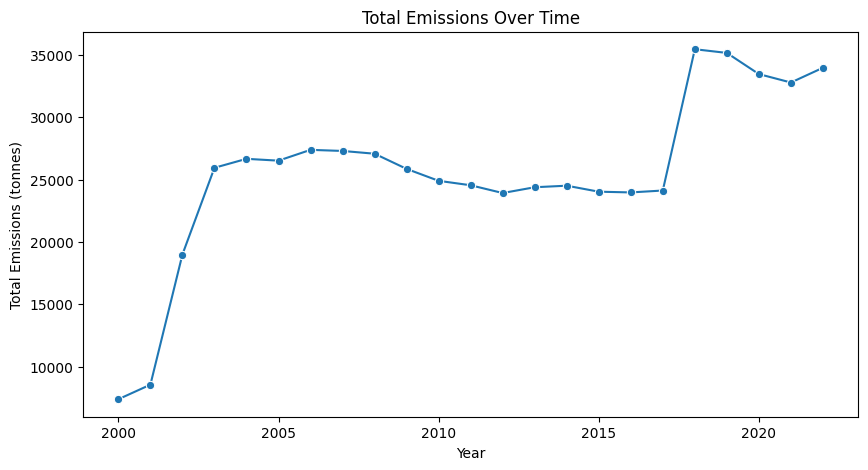

In [6]:
# Select relevant emission columns
# Updated column names to match the actual columns in the dataframe
emission_columns = [
    "Release to Air - Fugitive",
    "Releases to Air - Other Non-Point", # Corrected column name
    "Releases to Air - Road Dust",      # Corrected column name
    "Releases to Air - Spills",         # Corrected column name
    "Releases to Air - Stack / Point",  # Corrected column name
    "Releases to Air - Storage / Handling", # Corrected column name
    "Releases to Land - Leaks",         # Corrected column name
    "Releases to Land - Other",         # Corrected column name
    "Releases to Land - Spills",         # Corrected column name
    "Releases to Water Bodies - Direct Discharge", # Corrected column name
    "Releases to Water Bodies - Leaks",         # Corrected column name
    "Releases to Water Bodies - Spills"         # Corrected column name
]

# Print the actual column names in the dataframe for verification
print(df.columns)

# Calculate total emissions per record
# Use a loop to handle potential missing columns
df["Total_Emissions"] = 0  # Initialize the column
for column in emission_columns:
    if column in df.columns:  # Check if the column exists
        df["Total_Emissions"] += df[column]  # Add to total if it exists
    else:
        print(f"Warning: Column '{column}' not found in dataframe.")

# Group by year to create a time series dataset
df_time_series = df.groupby("Year")["Total_Emissions"].sum().reset_index()

# Display the transformed time series dataset
print(df_time_series.head())

# Plot emissions over time
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_time_series["Year"], y=df_time_series["Total_Emissions"], marker="o")
plt.xlabel("Year")
plt.ylabel("Total Emissions (tonnes)")
plt.title("Total Emissions Over Time")
plt.show()

Emission_Category
Medium    11
Low        6
High       6
Name: count, dtype: int64


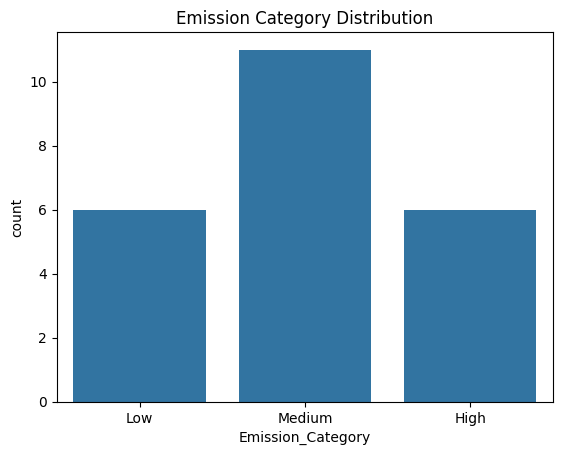

In [7]:
# Define emission categories based on quartiles
def classify_emission(value):
    if value > df_time_series["Total_Emissions"].quantile(0.75):
        return "High"
    elif value > df_time_series["Total_Emissions"].quantile(0.25):
        return "Medium"
    else:
        return "Low"

# Apply classification
df_time_series["Emission_Category"] = df_time_series["Total_Emissions"].apply(classify_emission)

# Check distribution
print(df_time_series["Emission_Category"].value_counts())

# Visualize category distribution
sns.countplot(x=df_time_series["Emission_Category"])
plt.title("Emission Category Distribution")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and labels
X = df_time_series.drop(columns=["Emission_Category", "Year"])
y = df_time_series["Emission_Category"]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training size: {len(X_train)}, Test size: {len(X_test)}")

Training size: 18, Test size: 5


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         Low       0.67      1.00      0.80         2
      Medium       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

Accuracy Score: 0.8


In [10]:
# Save processed data with labels
df_time_series.to_csv("processed_emission_data.csv", index=False)

# Save the trained model (optional)
import joblib
joblib.dump(model, "emission_classification_model.pkl")

['emission_classification_model.pkl']